In [ ]:
#default_exp core

# Core XLA extensions

In [ ]:
#exporti
#colab
IN_COLAB = True

In [ ]:
#hide
#colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    IN_COLAB = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#hide
#colab
import os
if IN_COLAB:
    assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [ ]:
#hide
#colab
![ -d /content ] && [ ! -d /content/data ] && curl -s https://course19.fast.ai/setup/colab | bash 

## Install fastai

Use latest fastai and fastcore versions

In [ ]:
#hide_output
#colab
![ -d /content ] && pip install -Uqq fastcore --upgrade
![ -d /content ] && pip install -Uqq fastai --upgrade

## Setup torch XLA


This is the official way to install Pytorch-XLA 1.7 [instructions here](https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb#scrollTo=CHzziBW5AoZH)

In [ ]:
#hide_output
#colab
![ -d /content ] && pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

In [ ]:
#hide
#colab
# use this for getting pytorch XLA nightly version
# VERSION = "20200707"  #@param ["1.5" , "20200325","20200707", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [ ]:
#hide
!pip freeze | grep torch
!pip freeze | grep fast

torch==1.7.0+cu101
torch-xla==1.7
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.8.1+cu101
fastai==2.1.9
fastcore==1.3.12
fastdtw==0.3.4
fastprogress==1.0.0
fastrlock==0.5


In [ ]:
#hide
#colab
%cd /content/drive/MyDrive/fastai_xla_extensions

/content/drive/MyDrive/fastai_xla_extensions


## Check if XLA is available

In [ ]:
#exporti
DEBUG = False # set to false for prod release
TRACE = False # set to false for prod release

In [ ]:
#exporti
if DEBUG:
    from pdb import set_trace
else:
    from fastcore.imports import noop
    set_trace = noop

In [ ]:
#export
#hide_output
import importlib
import os
import sys

def xla_imported(): return 'torch_xla' in sys.modules
# currently unused, might be deleted later?
def xla_available_config(): return os.environ.get("XRT_DEVICE_MAP", False) and os.environ.get("XRT_WORKERS", False)
def xla_module_exist(): return importlib.util.find_spec('torch_xla')

This next code routine handles the possibility of running the package when the environment does not provide a TPU (e.g. CI env, local, etc) by providing mock implementations 

In [ ]:
#exporti
import warnings
try:
    import torch_xla
except ImportError as e:
    if DEBUG: warnings.warn('TPU environment not available')
    

In [ ]:
#exporti
if not xla_imported():
    from types import SimpleNamespace
    import torch.cuda
    def fake_opt_step(opt,barrier=False):
        opt.step()
    def fake_device(n=None, devkind=None):
        gpu_available = torch.cuda.is_available()
        return torch.device(torch.cuda.current_device()) if gpu_available else torch.device('cpu')
    xm = SimpleNamespace(
        optimizer_step = fake_opt_step,
        xla_device = fake_device
    )
else:
    import torch_xla.core.xla_model as xm

## Patching BaseOptimizer to be Pickable
Patching Base Optimizer `__getstate__` and `__setstate__` whichi is used in pickling
the optimizer which should fix the bug in running the learner in multiple TPU cores
in XLA by which the  `def _fetch_gradients(optimizer)` in `for param_group in optimizer.__getstate__()['param_groups']:` fails, and this patch fixes the "copy constructor" to include the param_groups.

In [ ]:
#export
# from fastcore.foundation import GetAttr
# from fastai.optimizer import Optimizer
# from copy import deepcopy

# Right now deciding to patch BaseOptimizer instead of add with a PickableOpt(Optimizer) class like in previous versions
from fastcore.basics import patch_to
from fastai.optimizer import _BaseOptimizer

@patch_to(_BaseOptimizer)
def __getstate__(self):
    # https://github.com/pytorch/pytorch/blob/46b252b83a97bba0926cead050d76fcef129cb6b/torch/optim/optimizer.py#L54
    d = {
            'defaults': self.defaults,
            'state': self.state_dict(),
            'param_groups': self.param_groups,
        }
    return d

@patch_to(_BaseOptimizer)
def __setstate__(self, data):
    # https://github.com/pytorch/pytorch/blob/46b252b83a97bba0926cead050d76fcef129cb6b/torch/optim/optimizer.py#L61
    self.defaults = data['defaults']
    self.load_state_dict(data['state'])
    self.param_groups = data['param_groups']

## XLA Optim Proxy
`XLAOptimProxy` is a class which has overridden the `step` method to call the Pytorch-XLA function `xm.optimizer_step` which synchronizes the XLA graph. All other calls to `XLAOptimProxy` just forward it to the internal `self.opt` instance.

In [ ]:
#export
#colab
# import torch_xla.core.xla_model as xm

In [ ]:
#export
from fastcore.foundation import GetAttr

class XLAOptimProxy(GetAttr):
    _default='opt'
    "Proxy optimizer to override `opt.step` with Pytorch XLA sync method `xm.optimizer_step` "
    def __init__(self,opt, barrier):
        self.opt = opt # because not using PickableOpt(opt) for the moment
        self._barrier = barrier

    def step(self):
        xm.optimizer_step(self.opt,barrier=self._barrier) 

    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

## DeviceMoverTransform
`DeviceMoverTransform` is a simple transform that moves the batch input from the CPU to the XLA device. 

This is in lieu of the normal mechanism of the DataLoader implementation where the dls.device is set to the XLA device before the start of any batch transformations in the dataloaders.

Unfortunately, the AffineCoordTfm which is used for data augmentation (all the batch Zoom, Warp, Rotate augmentations) cause a problem when run on the TPU due to some affine operations not currently implemented in the Pytorch XLA) which triggers a lowering of the XLA Tensors to the CPU to perform the affine operation and causes a massive slowdown, even much slower than just doing the affine transform in the CPU in the first place.

The solution is then to postpone the moving of the input batch to TPU after the affine transformation, by setting the dls.device to None, which is done in the before_fit method of the XLAOptCallback. 


In [ ]:
#export
from fastcore.transform import DisplayedTransform
from torch import Tensor
import torch
class DeviceMoverTransform(DisplayedTransform):
    "Transform to move input to new device and reverse to cpu"
    def __init__(self, device_to, device_from=torch.device('cpu')):
        store_attr('device_to,device_from')
    def encodes(self, o:Tensor):
        return o.to(self.device_to)
    def decodes(self, o:Tensor):
        return o.to(self.device_from)


In [ ]:
#export
from fastcore.transform import Transform
from fastai.vision.augment import AffineCoordTfm, RandomResizedCropGPU
from fastai.data.core import DataLoaders,DataLoader

def _isAffineCoordTfm(o:Transform):
    return isinstance(o,(AffineCoordTfm,RandomResizedCropGPU))

def _isDeviceMoverTransform(o:Transform):
    return isinstance(o,DeviceMoverTransform)

def has_affinecoord_tfm(dls: DataLoaders) -> bool:
    "returns true if train dataloader has an AffineCoordTfm in the batch_tfms"
    idxs = dls.train.after_batch.fs.argwhere(_isAffineCoordTfm)
    return len(idxs) > 0
def has_devicemover_tfm(dl: DataLoader) -> bool:
    "returns true if train dataloader has a DeviceMoverTransform in the batch_tfms"
    idxs = dl.after_batch.fs.argwhere(_isDeviceMoverTransform)
    return len(idxs) > 0

def get_last_affinecoord_tfm_idx(dl:DataLoader)-> int: # -1 if none
    "returns index of last AffineCoordTfm if it exists, otherwise returns -1"
    idxs = dl.after_batch.fs.argwhere(_isAffineCoordTfm)
    return -1 if len(idxs) == 0 else idxs[-1]


In [ ]:
#export
def insert_batch_tfm(dl:DataLoader, batch_tfm:Transform, idx:int):
    "adds a batch_tfm in the batch_tfms for the dataloader at idx location"
    dl.after_batch.fs.insert(idx, batch_tfm)
 

In [ ]:
   
#export
from fastai.learner import Learner

def setup_input_device_mover(learn: Learner, new_device):
    "setup batch_tfms to use cpu if dataloader batch_tfms has AffineCoordTfms"
    if not has_affinecoord_tfm(learn.dls):
        learn.dls.device = new_device
        return
    learn.dls.device = None
    if has_devicemover_tfm(learn.dls.train):
        return # skip adding device mover if already added
    dm_tfm = DeviceMoverTransform(new_device)
    for dl in learn.dls.loaders:
        if not has_devicemover_tfm(dl):
            idx = get_last_affinecoord_tfm_idx(dl)
            if DEBUG: print(f'setup device mover dl: {dl} idx: {idx}')
            if idx != -1:
                insert_batch_tfm(dl, dm_tfm, idx+1)


## XLA Opt Callback
This callback replaces the learner's `opt` with an instance of `XLAOptimProxy` that proxies the original `opt` during the beginning of the `fit` method and restores the original `opt` after the `fit`.

It also sets the `dataloaders.device` and the `learn.model` to use a TPU core using the device returned by the `xm.xla_device()` method.

In [ ]:
#export
from fastai.callback.core import Callback
from fastai.data.core import DataLoaders
from fastai.vision.all import to_device
from fastai.callback.core import TrainEvalCallback
from fastai.learner import Recorder

class XLAOptCallback(Callback):
    'Callback to replace `opt.step` with `xm.optimizer_step(opt)` as required to run on TPU'
    run_after,run_before = TrainEvalCallback,Recorder
    def __init__(self, barrier=True):
        self._barrier = barrier

    def before_fit(self):
        'replace opt with proxy which calls `xm.optimizer_step` instead of `opt.step` and set `dls.device` and model to `xla_device`'
        # set dls device to none so prevent trigger of moving to batch input to XLA device
        # as this move will be done by the DeviceMoverTransform which has been added to the dls after_batch tfms
        if has_affinecoord_tfm(self.dls):
            self.dls.device = None

        if self.learn.opt is not None:
            if not isinstance(self.learn.opt,XLAOptimProxy):
                # force opt to reinitialize its parameters and make sure its parameters
                opt = self.learn.opt
                self.learn.opt = XLAOptimProxy(opt, barrier=self._barrier)
        
    def after_fit(self):
        'restore original opt '
        if isinstance(self.learn.opt, XLAOptimProxy):
            opt = self.learn.opt.opt
            self.learn.opt = opt
    @property
    def barrier(self): return self._barrier
    @barrier.setter
    def barrier(self,v): self._barrier = v

If XLA is available, then it is assumed that XLA is intended 
to be used -- this requires the following:



* The `XLAOptCallback` (which enables the `Learner` to call `xm.optimizer_step` via the `XLAOptimProxy`) is not automatically added as a default callback. 

In [ ]:
#export
# from fastcore.foundation import defaults
# if hasattr(defaults,'callbacks'):
#     if XLAOptCallback not in defaults.callbacks:
#         defaults.callbacks.append(XLAOptCallback)
# else:
#     defaults.callbacks = [XLAOptCallback]

* Override the `Learner.summary` method to set the `learner.dls` to use an `xla_device`

In [ ]:
#export
# if xla_imported():
#     from fastcore.foundation import patch
#     from fastai.learner import Learner
#     @patch
#     def move2_xla_device(self:Learner):
#         if DEBUG: print('call move2_xla_device')
#         if TRACE: set_trace()
#         if not hasattr(self,'xla_model_device'):
#             xla_model_device = xm.xla_device() 
#             if DEBUG: print(f'move2_xla_device: moving dls, model to {xla_model_device}')
#             self.model.to(xla_model_device)
#             self.dls.device = xla_model_device
#             self.xla_model_device = xla_model_device
        

In [ ]:
#export
# if xla_imported():
#     from fastcore.foundation import patch
#     from fastai.learner import Learner
#     from fastai.callback.hook import *
#     orig_summary = Learner.summary
#     @patch
#     def summary(self:Learner):
#         self.move2_xla_device()
#         return orig_summary(self)
   
    

* Make sure the model and dataloader has been moved to the xla device prior to creating the optimizer

In [ ]:
#export
# if xla_imported():
#     from fastai.learner import Learner
#     orig_create_opt = Learner.create_opt
    

In [ ]:
#export
# if xla_imported():
#     @patch
#     def create_opt(self:Learner):        
#         if DEBUG: print('creating opt')
#         self.move2_xla_device()
#         orig_create_opt(self)

In [ ]:
from fastcore.foundation import patch
#export
@patch
def to_xla(self:Learner, new_device=None):
    self.add_cb(XLAOptCallback())
    if new_device is None:
        new_device = xm.xla_device()
    self.model.to(new_device)
    setup_input_device_mover(self, new_device)
    self.opt = None
    return self


In [ ]:
#export
@patch
def detach_xla(self:Learner):
    self.remove_cb(XLAOptCallback)
    self.dls.device = torch.device('cpu')
    self.model.to(self.dls.device)
    self.opt = None
    return self

## Example: Create an MNIST classifier
This is an example of the fastai_xla_extensions library
in action.

First, we import fastai libraries. 

In [ ]:
#hide
#colab
%cd /content

/content


In [ ]:
from fastai.vision.all import *
from fastai.callback.training import GradientAccumulation

Load data

In [ ]:
path = untar_data(URLs.MNIST_TINY)
Path.BASE_PATH = path

Create datablock


In [ ]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    splitter=GrandparentSplitter(),
    item_tfms=Resize(28),
    batch_tfms=aug_transforms(do_flip=False, min_scale=0.8) # trigger usage of RandomResizedCropGPU
    # batch_tfms=[]
)

Set dataloader to load the batches to the cpu 

In [ ]:
dls = datablock.dataloaders(path)

In [ ]:
dls.device

device(type='cpu')

In [ ]:
dls.train.after_batch.fs

(#4) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ]

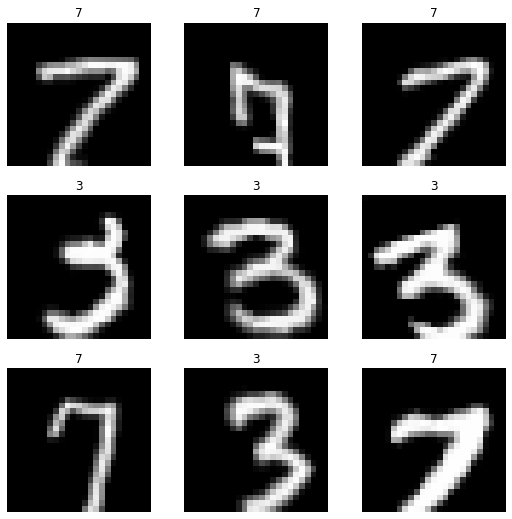

In [ ]:
# dls.show_batch()

Create the Learner


In [ ]:
learner = cnn_learner(dls, resnet18, metrics=accuracy)
# learner = cnn_learner(dls, resnet18, pretrained=False, metrics=accuracy) # see current bug re pretrained https://github.com/butchland/fastai_xla_extensions/issues/14 

In [ ]:
learner.dls.train.after_batch.fs

(#5) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -- {'mean': tensor([[[[0.4850]],

         [[0.4560]],

         [[0.4060]]]]), 'std': tensor([[[[0.2290]],

         [[0.2240]],

         [[0.2250]]]]), 'axes': (0, 2, 3)}:
en

In [ ]:
DEBUG = True

In [ ]:
#colab
learner.to_xla(xm.xla_device());

setup device mover dl: <fastai.data.core.TfmdDL object at 0x7ff3028a9a90> idx: 2


In [ ]:
learner.dls.device is None

True

In [ ]:
learner.dls.train.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

In [ ]:
learner.dls.valid.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

The `learner` object should have an `xla_opt` attribute which confirms that `XLAOptCallback` has been added to the list of callbacks for this learner.

In [ ]:
learner.xla_opt

XLAOptCallback

In [ ]:
#colab
learner.xla_opt.barrier

True

In [ ]:
learner.dls.device is None

True

In [ ]:
learner.opt is None

True

In [ ]:
one_param(learner.model).device

device(type='xla', index=1)

In [ ]:
has_affinecoord_tfm(learner.dls)

True

In [ ]:
has_devicemover_tfm(learner.dls.train)

True

In [ ]:
TRACE = False

In [ ]:
#colab
# currently an unrelated bug : https://github.com/fastai/fastai/issues/3011
# learner.summary()

In [ ]:
#colab
# learner.show_training_loop()

In [ ]:
learner.opt is None

True

In [ ]:
learner.dls.device

In [ ]:
#colab
class CheckXLADeviceCallback(Callback):
    def before_fit(self):
        if self.dls.device is not None:
            print(f'dls device: {self.dls.device} model device: {one_param(self.learn.model).device}')
        else:
            print(f'dls device: None model device: {one_param(self.learn.model).device}')
        if self.learn.opt is not None:
            param = first(self.learn.opt.all_params())[0]
            print(f'opt param device: {param.device}')

    def before_epoch(self):
        if self.dls.device is not None:
            print(f'dls device: {self.dls.device} model device: {one_param(self.learn.model).device}')
        else:
            print(f'dls device: None model device: {one_param(self.learn.model).device}')

Run `fit` to train the model.

In [ ]:
learner.fine_tune(6,freeze_epochs=4, cbs=CheckXLADeviceCallback())

dls device: None model device: xla:1
opt param device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,1.044283,0.589799,0.586552,00:42
1,0.856989,0.333799,0.852647,00:12
2,0.710016,0.321834,0.865522,00:14
3,0.624200,0.324638,0.871245,00:15


dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
opt param device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,0.465133,0.254103,0.912732,00:20
1,0.388323,0.191366,0.925608,00:14
2,0.324011,0.139396,0.949928,00:09
3,0.281545,0.108739,0.964235,00:09
4,0.230670,0.099597,0.965665,00:03
5,0.201774,0.100754,0.961373,00:03


dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1
dls device: None model device: xla:1


In [ ]:
learner.dls.train.after_batch.fs

(#6) [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
,Warp -- {'magnitude': 0.2, 'p': 1.0, 'draw_x': None, 'draw_y': None, 'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'batch': False, 'align_corners': True, 'mode_mask': 'nearest'}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ,RandomResizedCropGPU -- {'size': None, 'min_scale': 0.8, 'ratio': (1, 1), 'mode': 'bilinear', 'valid_scale': 1.0, 'p': 1.0}:
encodes: (TensorImage,object) -> encodes
decodes: ,DeviceMoverTransform -- {'device_to': device(type='xla', index=1), 'device_from': device(type='cpu')}:
encodes: (Tensor,object) -> encodes
decodes: (Tensor,object) -> decodes
,Brightness -- {'max_lighting': 0.2, 'p': 1.0, 'draw': None, 'batch': False}:
encodes: (TensorImage,object) -> encodes
decodes: ,Normalize -

In [ ]:
# learner.detach_xla()

In [ ]:
learner.dls.device is None

True

In [ ]:
learner.opt is None

False

In [ ]:
one_param(learner.model).device

device(type='xla', index=1)

In [ ]:
learner.save('stage-1')

Path('models/stage-1.pth')

In [ ]:
learner = cnn_learner(dls,resnet18, metrics=accuracy)

In [ ]:
learner.load('stage-1')

In [ ]:
learner.to_xla()

In [ ]:
learner.dls.device is None

True

In [ ]:
learner.fit_flat_cos(1,cbs=CheckXLADeviceCallback())

dls device: None model device: xla:1
opt param device: xla:1


epoch,train_loss,valid_loss,accuracy,time
0,0.148499,0.091807,0.962804,00:29


dls device: None model device: xla:1


In [ ]:
learner.detach_xla()

In [ ]:
learner.export()

RuntimeError: ignored

In [ ]:
one_param(learner.model).device

In [ ]:
learner.save('stage-2')

In [ ]:
learner.load('stage-2')

In [ ]:
test_images = get_image_files(path/'valid')

In [ ]:
learner.save()

In [ ]:
learner.fine_tune(6, freeze_epochs=4, cbs=CheckXLADeviceCallback())

In [ ]:
learner.dls.train.after_batch.fs

In [ ]:
learner.lr_find()

In [ ]:
# from IPython.core.debugger import set_trace
# def call_fit(learner,epochs=1):
#     set_trace()
#     learner.fit(epochs, cbs=[CheckXLADeviceCallback()])

In [ ]:
TRACE = False

In [ ]:
learner.fit_one_cycle(5, lr_max=slice(2e-2))

In [ ]:
learner.save('stage-1')

In [ ]:
learner.unfreeze()

In [ ]:
learner.lr_find()

In [ ]:
learner.fit_one_cycle(5, lr_max=slice(1e-6,1e-4))

In [ ]:
# call_fit(learner)

In [ ]:
#colab
learner.fine_tune(1, freeze_epochs=4, cbs=[CheckXLADeviceCallback()])

In [ ]:
learner.unfreeze()

In [ ]:
learner.save('stage-1')

In [ ]:
learner.lr_find()

In [ ]:
#colab
learner.fit_one_cycle(5,lr_max=slice(2e-6,7e-4))

In [ ]:
#colab
learner.fit_one_cycle(4, lr_max=slice(1e-6,1e-4))

Gradient Accum callback (which calls CancelBatchException) should still work.

An alternative design for the XLA Opt Callback which raises the CancelBatchException in the `after_backward` method (after executing `xm.optimizer_step` and `opt.zero_grad`) would interfere with the Gradient Accum callback (which raises `CancelBatchException` in the `after_backward` method to [skip the gradient updates](https://github.com/fastai/fastai/blob/master/fastai/callback/training.py#L22) in order to accumulate the gradients).

The current design (add/remove `XLAOptimProxy` during `before_fit` and `after_fit` callback lifecycle methods) is less disruptive and more compatible with other callbacks.

In [ ]:
#colab
learner.fit_one_cycle(4,cbs=[GradientAccumulation(n_acc=2),])

Valid loss has kind of plateaued so this look ok.  

In [ ]:
#colab
learner.recorder.plot_loss()

Plot moms and lr across batches/epochs

In [ ]:
#colab
learner.recorder.plot_sched()

Get Classification Interpretation for more details on model performance

In [ ]:
#colab
interp = ClassificationInterpretation.from_learner(learner)

Plot confusion matrix

In [ ]:
#colab
interp.plot_confusion_matrix()

Samples where model was most confused

In [ ]:
#colab
interp.plot_top_losses(12)

**End of Notebook**